<a href="https://colab.research.google.com/github/jonathanAmancioSales/Dados_Antaq/blob/main/Antaq_Questoes_a_b_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
A) Olhando para todos os dados disponíveis na fonte http://web.antaq.gov.br/Anuario/,
em qual estrutura de banco de dados você orienta guardá-los no nosso
Data Lake? SQL ou NoSQL? Discorra sobre sua orientação.
```
A utilização de um banco de dados relacional (SQL) é o recomendado nessa situação, uma vez que os dados obtidos são dados estruturados e, além disso, estão relacionados entre si.

```
B) Nosso cliente estipulou que necessita de informações apenas sobre
as atracações e cargas contidas nessas atracações dos últimos 3 anos (2017-2019).

Desenvolva um script em python que extraia os dados do anuário, e
transforme-os em duas tabelas fato, atracacao_fato e carga_fato,
com as respectivas colunas abaixo.
```

#Bibliotecas

In [1]:
import os
import fnmatch
import urllib.request
from zipfile import ZipFile

import numpy as np
import pandas as pd

from IPython.display import display

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.4)
sns.set_style({'font.family': 'serif','fontname': 'Times New Roman'})

#Download do conjunto de dados

In [4]:
%%time

#Escolha o Ano [2010-2021]:
Lista_Anos=[2017,2018,2019]
for Ano in Lista_Anos:
  File_zip=f'{Ano}.zip'
  url='http://web.antaq.gov.br/Sistemas/ArquivosAnuario/Arquivos/'+File_zip
  print(url,File_zip)

  if not os.path.exists(File_zip):
    File = urllib.request.urlretrieve(url, File_zip)

  z = ZipFile(File_zip, 'r')
  z.extractall()
  z.close()

http://web.antaq.gov.br/Sistemas/ArquivosAnuario/Arquivos/2017.zip 2017.zip
http://web.antaq.gov.br/Sistemas/ArquivosAnuario/Arquivos/2018.zip 2018.zip
http://web.antaq.gov.br/Sistemas/ArquivosAnuario/Arquivos/2019.zip 2019.zip
CPU times: user 7.58 s, sys: 2.91 s, total: 10.5 s
Wall time: 4min 2s


In [5]:
TemposAtracacao      =fnmatch.filter(os.listdir(), '*TemposAtracacao.txt')
Atracacao            =fnmatch.filter(os.listdir(), '*Atracacao.txt')
Atracacao            =list(set(Atracacao) - set(TemposAtracacao))

Carga                =fnmatch.filter(os.listdir(), '*Carga.txt')
Carga_Conteinerizada =fnmatch.filter(os.listdir(), '*Carga_Conteinerizada.txt')

# Atracação

## Atracacao.txt

In [6]:
#Importar dataframe
L=Atracacao
df = pd.read_csv(L[0], index_col=0, sep=';')

print(L[0])
if len(L)>1:
  for f in L[1:]:
    print(f)
    aux = pd.read_csv(f, index_col=0, sep=';')
    df = pd.concat([df,aux]).copy()

df_At=df.copy()
del df

2017Atracacao.txt
2019Atracacao.txt
2018Atracacao.txt


In [7]:
df_At.reset_index(level=0,inplace=True)
df_At.sample(2)

,IDAtracacao,CDTUP,IDBerco,Berço,Porto Atracação,Apelido Instalação Portuária,Complexo Portuário,Tipo da Autoridade Portuária,Data Atracação,Data Chegada,Data Desatracação,Data Início Operação,Data Término Operação,Ano,Mes,Tipo de Operação,Tipo de Navegação da Atracação,Nacionalidade do Armador,FlagMCOperacaoAtracacao,Terminal,Município,UF,SGUF,Região Geográfica,Nº da Capitania,Nº do IMO
181479,905162,BRSSZ,SSZ0627,OUTEIRINHOS 2,Santos,NaN,Santos,Porto Público,04/02/2018 08:45:00,04/02/2018 08:00:00,04/02/2018 17:40:00,04/02/2018 08:45:00,04/02/2018 17:40:00,2018,fev,Passageiro,Longo Curso,2.0,1,Cais Público - Outeirinhos,Santos,São Paulo,SP,Sudeste,NaN,9387085.0
114130,1010532,BRRIG,RIG3311,TECON - BERÇO I,Rio Grande,NaN,Rio Grande,Porto Público,08/06/2019 02:40:00,07/06/2019 23:20:00,08/06/2019 07:45:00,08/06/2019 02:41:00,08/06/2019 07:37:00,2019,jun,Movimentação da Carga,Interior,1.0,1,TECON,Rio Grande,Rio Grande do Sul,RS,Sul,4620187372,NaN


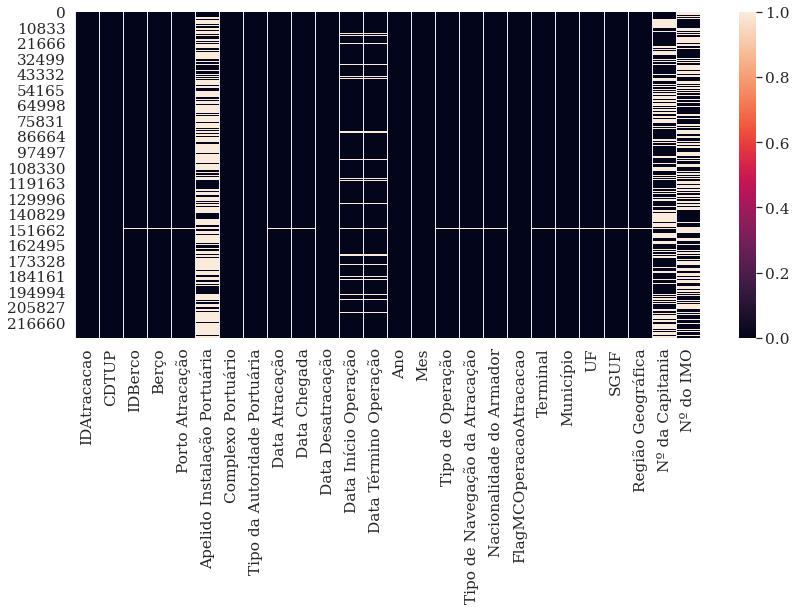

In [8]:
#Verificando valores nulos:
plt.figure(figsize=(14,6))
sns.heatmap(df_At.isnull())
plt.show()

##### Ano e Mês

Obs: Nos arquivos 'MetadadosAtracacao.txt' e 'MetadadosTemposAtracacao.txt' não encontrei informações sobre as colunas 'Ano' e 'Mes' presentes nos arquivos '2017Atracacao.txt', '2018Atracacao.txt', etc.

Já, no arquivo 'Projeto -  Engenheiro de dados.pdf', são apresentadas as colunas 'Mês da data de início da operação' e 'Ano da data de início da operação'.

Entretanto, como se pode ver no Exemplo 1 abaixo, supondo que este dado esteja correto, o 'Mes' é diferente do mês da 'Data Início Operação', provavelmente se refere ao mês ou da 'Data Desatracação' ou da 'Data Término Operação'.
Por outro lado, no Exemplo 2 (assim como em muitos outros casos), a única data presente é a 'Data Desatracação'.

Portanto, faz mais sentido que 'Mes' e 'Ano' se refiram à 'Data Desatracação'.

In [9]:
#Exemplo 1:
filtro=df_At['IDAtracacao']==1033424
df_At.loc[filtro,['IDAtracacao','Data Atracação','Data Desatracação','Data Início Operação','Data Término Operação','Mes','Ano']]

,IDAtracacao,Data Atracação,Data Desatracação,Data Início Operação,Data Término Operação,Mes,Ano
227468,1033424,26/11/2018 21:36:00,01/12/2018 10:02:00,26/11/2018 21:37:00,01/12/2018 10:01:00,dez,2018


In [11]:
#Exemplo 2:
filtro=df_At['IDAtracacao']==2487
df_At.loc[filtro,['IDAtracacao','Data Atracação','Data Desatracação','Data Início Operação','Data Término Operação','Mes','Ano']]

,IDAtracacao,Data Atracação,Data Desatracação,Data Início Operação,Data Término Operação,Mes,Ano
151391,2487,NaN,01/10/2018 00:00:00,NaN,NaN,out,2018


De qualquer forma, renomei as colunas 'Mes' e 'Ano' para ficarem de acordo com o pdf.

In [12]:
df_At=df_At.rename(columns={"Mes": "Mês da data de início da operação", "Ano": "Ano da data de início da operação"})

##### 'Nº do IMO'

In [13]:
#Uma que zero não é um 'Nº do IMO' válido e são inteiros...
#Trocar NaN por 0 e Converter float para int:
df_At['Nº do IMO']=df_At['Nº do IMO'].fillna(0).astype('int64')

##### Trocar tipo de algumas colunas para categoria

In [14]:
display( df_At['Nacionalidade do Armador'].astype('category').unique() )

#Trocar NaN por 0, considerando 0 quando o valor (1|2) não é informado:
df_At['Nacionalidade do Armador']=df_At['Nacionalidade do Armador'].fillna(0).map(lambda v:int(v))

display( df_At['Nacionalidade do Armador'].astype('category').unique() )

[NaN, 1.0, 2.0, 0.0]
Categories (3, float64): [1.0, 2.0, 0.0]

[0, 1, 2]
Categories (3, int64): [0, 1, 2]

In [15]:
Lista=['Tipo da Autoridade Portuária','Tipo de Operação', 'Tipo de Navegação da Atracação',
       'Nacionalidade do Armador', 'FlagMCOperacaoAtracacao','UF', 'SGUF', 'Região Geográfica',
       'Mês da data de início da operação']

#Altera tipo objetos_string para categoria:
for col in Lista:
  df_At[col]= df_At[col].astype('category')

In [16]:
df_At['Mês da data de início da operação'].cat.reorder_categories(['jan','fev','mar','abr',
                                                                   'mai','jun','jul','ago',
                                                                   'set','out','nov','dez'],
                                                                   ordered=True, inplace=True)

In [17]:
df_At['Mês da data de início da operação'].unique()

['ago', 'jul', 'jun', 'fev', 'abr', ..., 'dez', 'set', 'mai', 'out', 'mar']
Length: 12
Categories (12, object): ['jan' < 'fev' < 'mar' < 'abr' ... 'set' < 'out' < 'nov' < 'dez']

In [18]:
df_At.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227472 entries, 0 to 227471
Data columns (total 26 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   IDAtracacao                        227472 non-null  int64   
 1   CDTUP                              227472 non-null  object  
 2   IDBerco                            226411 non-null  object  
 3   Berço                              226411 non-null  object  
 4   Porto Atracação                    226411 non-null  object  
 5   Apelido Instalação Portuária       81445 non-null   object  
 6   Complexo Portuário                 227472 non-null  object  
 7   Tipo da Autoridade Portuária       227472 non-null  category
 8   Data Atracação                     226411 non-null  object  
 9   Data Chegada                       226411 non-null  object  
 10  Data Desatracação                  227472 non-null  object  
 11  Data Início Operação      

## TemposAtracacao.txt

In [19]:
#Importar dataframe
L=TemposAtracacao
df = pd.read_csv(L[0], index_col=0, sep=';')

print(L[0])
if len(L)>1:
  for f in L[1:]:
    print(f)
    aux = pd.read_csv(f, index_col=0, sep=';')
    df = pd.concat([df,aux]).copy()

df_time_At=df.copy()
del df

2019TemposAtracacao.txt
2017TemposAtracacao.txt
2018TemposAtracacao.txt


In [20]:
df_time_At.reset_index(level=0,inplace=True)
df_time_At.sample(2)

,IDAtracacao,TEsperaAtracacao,TEsperaInicioOp,TOperacao,TEsperaDesatracacao,TAtracado,TEstadia
92300,871327,"0,66666666674428","2,3333333332557",3,"1,1666666666279","6,4999999998836","7,1666666666279"
185041,951215,"36,116666666698","0,28333333338378","2,4333333332324","0,11666666669771","2,8333333333139","38,950000000012"


In [21]:
#Trocar ',' por '.' e Converter em object/string em float:
for col in df_time_At.columns[df_time_At.dtypes=='object']:
  df_time_At[col]=df_time_At[col].astype('str').map( lambda v: v.replace(',','.') ).astype('float64')

In [22]:
#Alguns valores da tabela podem ser exibidos como se tivessem sido arredondados,
#mas note que isso é somente na exibição pois os valores não foram alterados:
display( df_time_At.query('IDAtracacao==892942') )
display( df_time_At.query('IDAtracacao==892942').astype('str') )

,IDAtracacao,TEsperaAtracacao,TEsperaInicioOp,TOperacao,TEsperaDesatracacao,TAtracado,TEstadia
225935,892942,1.0,0.0,0.0,0.0,23.0,24.0


,IDAtracacao,TEsperaAtracacao,TEsperaInicioOp,TOperacao,TEsperaDesatracacao,TAtracado,TEstadia
225935,892942,0.99999999994179,0.0,0.0,0.0,23.000000000058,24.0


## Tabela atracacao_fato

In [23]:
atracacao_fato = pd.merge(df_At, df_time_At, how="left", on="IDAtracacao")
atracacao_fato = atracacao_fato.sort_values(by=['IDAtracacao'], ignore_index=True)
atracacao_fato.sample(4)

,IDAtracacao,CDTUP,IDBerco,Berço,Porto Atracação,Apelido Instalação Portuária,Complexo Portuário,Tipo da Autoridade Portuária,Data Atracação,Data Chegada,Data Desatracação,Data Início Operação,Data Término Operação,Ano da data de início da operação,Mês da data de início da operação,Tipo de Operação,Tipo de Navegação da Atracação,Nacionalidade do Armador,FlagMCOperacaoAtracacao,Terminal,Município,UF,SGUF,Região Geográfica,Nº da Capitania,Nº do IMO,TEsperaAtracacao,TEsperaInicioOp,TOperacao,TEsperaDesatracacao,TAtracado,TEstadia
18847,833316,BRSP004,BRSP0048932,Cutrale,Sucocítrico Cutrale,NaN,Santos,Porto Privado,24/04/2017 13:22:00,24/04/2017 13:22:00,29/04/2017 07:42:00,25/04/2017 01:52:00,29/04/2017 03:02:00,2017,abr,Movimentação da Carga,Longo Curso,2,1,Sucocítrico Cutrale,Guarujá,São Paulo,SP,Sudeste,NaN,9342580,0.000000,12.500000,97.166667,4.666667,114.333333,114.333333
216502,1043661,BRIQI,IQI5008,BERÇO 108,Itaqui,NaN,Itaqui,Porto Público,30/10/2019 16:20:00,25/10/2019 17:02:00,03/11/2019 10:40:00,30/10/2019 23:55:00,03/11/2019 05:00:00,2019,nov,Movimentação da Carga,Longo Curso,2,1,Píer Público,São Luís,Maranhão,MA,Nordeste,NaN,9324459,119.300000,7.583333,77.083333,5.666667,90.333333,209.633333
35956,855844,BRRO013,BRRO0130001,Berço do Pier flutuante Portochuelo,Terminal de Expedição de Grãos Portochuelo,Amaggi Portochuelo,Porto Velho,Porto Privado,08/07/2017 18:20:00,08/07/2017 18:20:00,08/07/2017 19:45:00,08/07/2017 18:20:00,08/07/2017 19:45:00,2017,jul,Movimentação da Carga,Interior,1,1,Terminal de Expedição de Grãos Portochuelo,Porto Velho,Rondônia,RO,Norte,0011448474,0,0.000000,0.000000,1.416667,0.000000,1.416667,1.416667
163976,989420,BRES004,BRES0040702,2,Terminal Marítimo Alfandegado Privativo de Uso...,Terminal de Produtos Siderúrgicos,Vitória,Porto Privado,28/03/2019 22:10:00,27/03/2019 13:45:00,31/03/2019 12:35:00,28/03/2019 23:40:00,31/03/2019 08:35:00,2019,mar,Movimentação da Carga,Longo Curso,2,1,Terminal Marítimo Alfandegado Privativo de Uso...,Vitória,Espírito Santo,ES,Sudeste,NaN,9767704,32.416667,1.500000,56.916667,4.000000,62.416667,94.833333


In [24]:
atracacao_fato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227472 entries, 0 to 227471
Data columns (total 32 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   IDAtracacao                        227472 non-null  int64   
 1   CDTUP                              227472 non-null  object  
 2   IDBerco                            226411 non-null  object  
 3   Berço                              226411 non-null  object  
 4   Porto Atracação                    226411 non-null  object  
 5   Apelido Instalação Portuária       81445 non-null   object  
 6   Complexo Portuário                 227472 non-null  object  
 7   Tipo da Autoridade Portuária       227472 non-null  category
 8   Data Atracação                     226411 non-null  object  
 9   Data Chegada                       226411 non-null  object  
 10  Data Desatracação                  227472 non-null  object  
 11  Data Início Operação      

In [25]:
atracacao_fato.describe(include=['object','category'])

,CDTUP,IDBerco,Berço,Porto Atracação,Apelido Instalação Portuária,Complexo Portuário,Tipo da Autoridade Portuária,Data Atracação,Data Chegada,Data Desatracação,Data Início Operação,Data Término Operação,Mês da data de início da operação,Tipo de Operação,Tipo de Navegação da Atracação,Nacionalidade do Armador,FlagMCOperacaoAtracacao,Terminal,Município,UF,SGUF,Região Geográfica,Nº da Capitania
count,227472,226411,226411,226411,81445,227472,227472,226411,226411,227472,216153,216150,227472,226411,226411,227472,227472,226411,226411,226411,226411,226411,132227
unique,202,659,529,201,75,41,2,172602,138464,168892,168424,167822,12,8,5,3,1,273,82,21,21,5,2797
top,BRBEL,BEL0006,6F,Belém,TERMISA,Vila do Conde - Belém,Porto Privado,01/05/2018 00:01:00,19/07/2016 08:30:00,01/06/2017 00:00:00,17/02/2018 07:00:00,17/02/2018 19:00:00,ago,Movimentação da Carga,Interior,1,1,Cais Público,Belém,Pará,PA,Norte,0210254220
freq,14630,9601,9601,14630,5410,29272,124741,26,238,40,20,20,20430,179649,109190,149600,227472,29867,20450,48654,48654,92897,1243


In [26]:
#Escrever tabela em arquivo CSV:
atracacao_fato.to_csv('Tabela_atracacao_fato.csv', index=False)

# Carga

### Carga.txt

In [27]:
#Importar dataframe
df_Carga = pd.read_csv(Carga[0], index_col=0, sep=';')

print(Carga[0])
if len(Carga)>1:
  for f in Carga[1:]:
    print(f)
    aux = pd.read_csv(f, index_col=0, sep=';')
    df_Carga = pd.concat([df_Carga,aux]).copy()

2017Carga.txt
2018Carga.txt
2019Carga.txt


In [28]:
df_Carga.reset_index(level=0,inplace=True)

In [29]:
df_Carga.sample(2)

,IDCarga,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,ConteinerEstado,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagConteinerTamanho,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,Sentido,TEU,QTCarga,VLPesoCargaBruta
5531524,25005385,1031443,BRSSZ,BRSSA,45G0,Longo Curso Importação com Baldeação de Carga ...,Conteinerizada,Vazio,Cabotagem,S,0.0,1.0,40,0.0,1,0.0,0,NaN,NaN,Compartilhado,Compartilhado,Compartilhado,Carga Conteinerizada,Embarcados,2,1,4
3238848,22655465,944626,NaN,NaN,49G9,Remoção a bordo,Conteinerizada,NaN,Não Indentificado,S,0.0,0.0,40,0.0,0,0.0,0,NaN,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Não Informado,2,1,"9,04"


____________
Corrigir colunas (Alterar tipo, Substituir ',' por '.'):

In [30]:
Lista=['STNaturezaCarga', 'STSH2', 'STSH4', 'Natureza da Carga', 'Sentido',
       'Tipo Navegação', 'Carga Geral Acondicionamento', 'ConteinerEstado',
       'Tipo Operação da Carga', 'Percurso Transporte em vias Interiores',
       'Percurso Transporte Interiores', 'FlagAutorizacao']

#Altera tipo objetos_string para categoria:
for col in Lista:
  df_Carga[col] = df_Carga[col].astype('category')

In [31]:
df_Carga['TEU']=df_Carga['TEU'].map(lambda v:str(v)).map(lambda v:v.replace(',','.')).map(lambda v:float(v))

In [32]:
df_Carga['VLPesoCargaBruta']=df_Carga['VLPesoCargaBruta'].map(lambda v:v.replace(',','.')).map(lambda v:float(v))

In [33]:
%%time

df_Carga['FlagConteinerTamanho']=df_Carga['FlagConteinerTamanho'].map(lambda v:str(v)).map(lambda v:v.replace('.0',''))

Lista=[]
for idx in df_Carga.index:
  aux=df_Carga.loc[idx,'FlagConteinerTamanho']
  #if str(aux)=='nan': aux=np.nan
  if aux=='nan': aux=np.nan
  Lista.append( aux )

df_Carga['FlagConteinerTamanho']=pd.Series(Lista).astype('category')

CPU times: user 2min 10s, sys: 304 ms, total: 2min 10s
Wall time: 2min 10s


____________

In [34]:
df_Carga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6111668 entries, 0 to 6111667
Data columns (total 27 columns):
 #   Column                                  Dtype   
---  ------                                  -----   
 0   IDCarga                                 int64   
 1   IDAtracacao                             int64   
 2   Origem                                  object  
 3   Destino                                 object  
 4   CDMercadoria                            object  
 5   Tipo Operação da Carga                  category
 6   Carga Geral Acondicionamento            category
 7   ConteinerEstado                         category
 8   Tipo Navegação                          category
 9   FlagAutorizacao                         category
 10  FlagCabotagem                           float64 
 11  FlagCabotagemMovimentacao               float64 
 12  FlagConteinerTamanho                    category
 13  FlagLongoCurso                          float64 
 14  FlagMCOperacaoCarg

### Carga_Conteinerizada.txt

In [35]:
#Importar dataframe
df_CargaC = pd.read_csv(Carga_Conteinerizada[0], index_col=0, sep=';')

print(Carga_Conteinerizada[0])
if len(Carga_Conteinerizada)>1:
  for f in Carga_Conteinerizada[1:]:
    print(f)
    aux = pd.read_csv(f, index_col=0, sep=';')
    df_CargaC = pd.concat([df_CargaC,aux]).copy()

2018Carga_Conteinerizada.txt
2017Carga_Conteinerizada.txt
2019Carga_Conteinerizada.txt


In [36]:
df_CargaC.reset_index(level=0,inplace=True)
df_CargaC.sample(2)

,IDCarga,CDMercadoriaConteinerizada,VLPesoCargaConteinerizada
1271401,21144244,4011,"11,25"
769695,23243009,2933,"10,06"


In [37]:
#Trocar ',' por '.':
df_CargaC=df_CargaC.assign( VLPesoCargaConteinerizada = df_CargaC['VLPesoCargaConteinerizada'].astype('str').map( lambda v: v.replace(',','.') ) )

#Converter em object/string em float:
df_CargaC['VLPesoCargaConteinerizada']=df_CargaC['VLPesoCargaConteinerizada'].astype('float64')

In [38]:
df_CargaC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10545749 entries, 0 to 10545748
Data columns (total 3 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   IDCarga                     int64  
 1   CDMercadoriaConteinerizada  object 
 2   VLPesoCargaConteinerizada   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 241.4+ MB


In [39]:
#Possui valores nulos?
df_CargaC.isnull().any()

IDCarga                       False
CDMercadoriaConteinerizada    False
VLPesoCargaConteinerizada     False
dtype: bool

In [40]:
%%time
df_CargaC_group=df_CargaC.groupby(['IDCarga']).agg({'CDMercadoriaConteinerizada':'unique','VLPesoCargaConteinerizada':'sum'})

CPU times: user 9min 55s, sys: 28 s, total: 10min 23s
Wall time: 9min 38s


In [41]:
df_CargaC_group=df_CargaC_group.rename(columns={'VLPesoCargaConteinerizada':'sumVLPesoCargaConteinerizada'})

In [42]:
df_CargaC_group.reset_index(level=0,inplace=True)
df_CargaC_group

,IDCarga,CDMercadoriaConteinerizada,sumVLPesoCargaConteinerizada
0,17765801,[4409],19.31
1,17765802,[4409],21.00
2,17765803,[0511],3.34
3,17765804,[0904],10.82
4,17765805,[4409],21.86
...,...,...,...
5185382,27705307,[0904],24.93
5185383,27705308,[0904],24.89
5185384,27705309,[0904],25.15
5185385,27705310,[0904],25.15


In [43]:
df_CargaC_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5185387 entries, 0 to 5185386
Data columns (total 3 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   IDCarga                       int64  
 1   CDMercadoriaConteinerizada    object 
 2   sumVLPesoCargaConteinerizada  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 118.7+ MB


## Tabela carga_fato

In [44]:
atracacao_fato_part=atracacao_fato[['IDAtracacao','Ano da data de início da operação',
                                    'Mês da data de início da operação','Porto Atracação','SGUF']]
atracacao_fato_part=atracacao_fato_part.rename(columns={'Mês da data de início da operação':'Mês da data de início da operação da atracação',
                                                        'Ano da data de início da operação':'Ano da data de início da operação da atracação'})

atracacao_fato_part

,IDAtracacao,Ano da data de início da operação da atracação,Mês da data de início da operação da atracação,Porto Atracação,SGUF
0,118,2017,jan,NaN,NaN
1,119,2017,jan,NaN,NaN
2,120,2017,jan,NaN,NaN
3,128,2017,jan,NaN,NaN
4,177,2017,jan,NaN,NaN
...,...,...,...,...,...
227467,1133345,2019,ago,Vila do Conde,PA
227468,1133346,2019,jul,Vila do Conde,PA
227469,1133633,2018,set,Vila do Conde,PA
227470,1133634,2018,set,Vila do Conde,PA


In [45]:
Carga_At = pd.merge(df_Carga, atracacao_fato_part, how="left", on="IDAtracacao")
Carga_At = Carga_At.sort_values(by=['IDCarga'], ignore_index=True)

#Carga_At.sample(12)
Carga_At

,IDCarga,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,ConteinerEstado,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagConteinerTamanho,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,Sentido,TEU,QTCarga,VLPesoCargaBruta,Ano da data de início da operação da atracação,Mês da data de início da operação da atracação,Porto Atracação,SGUF
0,118,118,BRQGA,BRQGA,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Estadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,66000.00,2017,jan,NaN,NaN
1,119,119,BRQGA,BR373,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Interestadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,9900.00,2017,jan,NaN,NaN
2,120,120,BRQGA,BR375,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Estadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,26400.00,2017,jan,NaN,NaN
3,128,128,BRQGA,PYZ06,3102,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Internacional,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,1425.90,2017,jan,NaN,NaN
4,177,177,BRQGA,PYZ06,2521,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Internacional,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,688.01,2017,jan,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6111663,27705307,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.73,2018,dez,Vila do Conde,PA
6111664,27705308,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.69,2018,dez,Vila do Conde,PA
6111665,27705309,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.95,2018,dez,Vila do Conde,PA
6111666,27705310,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.95,2018,dez,Vila do Conde,PA


In [46]:
carga_fato = pd.merge(Carga_At, df_CargaC_group, how="left", on="IDCarga")
carga_fato = carga_fato.sort_values(by=['IDCarga'], ignore_index=True)
carga_fato

,IDCarga,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,ConteinerEstado,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagConteinerTamanho,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,Sentido,TEU,QTCarga,VLPesoCargaBruta,Ano da data de início da operação da atracação,Mês da data de início da operação da atracação,Porto Atracação,SGUF,CDMercadoriaConteinerizada,sumVLPesoCargaConteinerizada
0,118,118,BRQGA,BRQGA,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Estadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,66000.00,2017,jan,NaN,NaN,NaN,NaN
1,119,119,BRQGA,BR373,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Interestadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,9900.00,2017,jan,NaN,NaN,NaN,NaN
2,120,120,BRQGA,BR375,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Estadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,26400.00,2017,jan,NaN,NaN,NaN,NaN
3,128,128,BRQGA,PYZ06,3102,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Internacional,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,1425.90,2017,jan,NaN,NaN,NaN,NaN
4,177,177,BRQGA,PYZ06,2521,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Internacional,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,688.01,2017,jan,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6111663,27705307,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.73,2018,dez,Vila do Conde,PA,[0904],24.93
6111664,27705308,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.69,2018,dez,Vila do Conde,PA,[0904],24.89
6111665,27705309,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.95,2018,dez,Vila do Conde,PA,[0904],25.15
6111666,27705310,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.95,2018,dez,Vila do Conde,PA,[0904],25.15


#### Coluna 'CDMercadoria'

```
CDMercadoria = {CDMercadoria:[Lista de código das mercadorias dentro do contêiner]} if carga conteinerizada
             = CDMercadoria                                                         if carga não conteinerizada
```

In [47]:
#Há elementos nulos?
carga_fato['CDMercadoria'].isnull().any()

False

No arquivo '{ano}carga.txt' de algum {ano} específico está presente a coluna 'CDMercadoria' que não possui nenhum valor ausente.

Pede-se que seja criada a tabela 'carga_fato' com a coluna 'CDMercadoria' onde se lê a seguinte observação: (Para carga conteinerizada informar código das mercadorias dentro do contêiner.).

Considerando que a tabela 'carga_fato' deve conter APENAS as colunas apresentadas na questão e nenhuma outra, uma possível solução para isso, é criar um dicionário ({key:value}) com o valor 'CDMercadoria' como chave e uma lista contendo os códigos 'CDMercadoriaConteinerizada' correspondentes como valor.

Destaco aqui que algumas cargas conteinerizadas não possuem os códigos das mercadorias.

In [48]:
filtro=(carga_fato['CDMercadoriaConteinerizada'].isnull()) & (carga_fato['Carga Geral Acondicionamento'].notnull()) #254819 rows
carga_fato.loc[filtro,['IDCarga','CDMercadoria','CDMercadoriaConteinerizada','Carga Geral Acondicionamento','ConteinerEstado']]

,IDCarga,CDMercadoria,CDMercadoriaConteinerizada,Carga Geral Acondicionamento,ConteinerEstado
1062,17713375,CA01,NaN,Solta,NaN
1078,17717423,7208,NaN,Solta,NaN
1079,17717430,7208,NaN,Solta,NaN
1241,17766920,7208,NaN,Solta,NaN
1265,17774302,7210,NaN,Solta,NaN
...,...,...,...,...,...
6107599,27699632,CA01,NaN,Solta,NaN
6108723,27701361,CA01,NaN,Solta,NaN
6109205,27701843,CA01,NaN,Solta,NaN
6109206,27701844,CA01,NaN,Solta,NaN


In [49]:
%%time
Lista=[]
for idx in carga_fato.index:
  aux=carga_fato.loc[idx,'CDMercadoriaConteinerizada']
  if str(aux)=='nan': aux=''
  Lista.append( {carga_fato.loc[idx,'CDMercadoria']:aux} )

CPU times: user 7min 20s, sys: 2.76 s, total: 7min 23s
Wall time: 7min 24s


In [50]:
carga_fato.insert(4, 'CDMercadoria2', pd.Series(Lista))

carga_fato=carga_fato.drop(columns=['CDMercadoria', 'CDMercadoriaConteinerizada'])

carga_fato.rename(columns={'CDMercadoria2':'CDMercadoria'},inplace=True)

In [51]:
carga_fato.sample(3)

,IDCarga,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,ConteinerEstado,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagConteinerTamanho,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,Sentido,TEU,QTCarga,VLPesoCargaBruta,Ano da data de início da operação da atracação,Mês da data de início da operação da atracação,Porto Atracação,SGUF,sumVLPesoCargaConteinerizada
1206051,20235515,873869,AOLAD,BRSSZ,{'45R1': ['45R1']},Movimentação de Carga,Conteinerizada,Vazio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,0,NaN,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Desembarcados,2.0,1,4.719,2017,set,Santos,SP,0.00
745103,19606259,848999,BRRIO,BRSSA,{'45G1': ['45G1']},Movimentação de Carga,Conteinerizada,Vazio,Cabotagem,S,1.0,1.0,40,0.0,1,0.0,0,NaN,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Desembarcados,2.0,1,3.740,2017,jun,Salvador,BA,0.00
1164602,20152202,871560,SGSIN,BRPNG,{'22R0': ['3812']},Movimentação de Carga,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,20,1.0,1,0.0,0,NaN,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Desembarcados,1.0,1,7.150,2017,set,Paranaguá,PR,4.65


#### Coluna 'Peso líquido da carga'

```
Peso líquido da carga = 'Peso bruto'         if Carga não conteinerizada 
                      = 'Peso sem contêiner' if Carga conteinerizada

'Peso líquido da carga' = 'VLPesoCargaBruta'               if 'Carga Geral Acondicionamento' == 'Solta'
                        = [Sum]'VLPesoCargaConteinerizada' if 'Carga Geral Acondicionamento' == 'Conteinerizada'
                        = 'VLPesoCargaBruta'               if 'Carga Geral Acondicionamento' ==  NaN
```

In [52]:
#Há algum valor nulo?
carga_fato['VLPesoCargaBruta'].isnull().any()

False

In [53]:
%%time
List=[]
for idx in carga_fato.index:
  if carga_fato.loc[idx,'Carga Geral Acondicionamento'] == 'Conteinerizada':
    value=carga_fato.loc[idx,'sumVLPesoCargaConteinerizada']
  else:
    value=carga_fato.loc[idx,'VLPesoCargaBruta']
  List.append( value )

CPU times: user 5min 3s, sys: 1.31 s, total: 5min 4s
Wall time: 5min 4s


In [54]:
carga_fato['Peso líquido da carga']=pd.Series(List)

carga_fato.drop(columns=['sumVLPesoCargaConteinerizada'],inplace=True)

In [55]:
carga_fato.sample(2)

,IDCarga,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,ConteinerEstado,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagConteinerTamanho,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,Sentido,TEU,QTCarga,VLPesoCargaBruta,Ano da data de início da operação da atracação,Mês da data de início da operação da atracação,Porto Atracação,SGUF,Peso líquido da carga
3827329,23266930,963455,BRSC008,BRSSZ,{'22G0': ['22G0']},Cabotagem,Conteinerizada,Vazio,Cabotagem,S,1.0,1.0,20,0.0,1,0.0,0,NaN,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Desembarcados,1.0,1,2.20,2018,nov,Santos,SP,0.00
5523363,24998164,1031329,BRRO005,BRAM007,{'22G0': ['9999']},Interior,Conteinerizada,Cheio,Interior,S,0.0,0.0,20,0.0,1,0.0,1,Interior Interestadual,Navegação Interior,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Desembarcados,1.0,1,18.51,2019,set,Chibatão Navegação e Comércio,AM,18.51


________________________

In [56]:
%%time
#Escrever tabela em arquivo CSV:
carga_fato.to_csv('Tabela_carga_fato.csv', index=False)

# Armazenando tabelas em Banco de Dados
________________________

In [57]:
from sqlalchemy import create_engine

In [58]:
eng = create_engine('sqlite:///Banco_Dados.db')

In [59]:
atracacao_fato.to_sql('atracacao_fato', con=eng, index=False)

carga_fato.to_sql('carga_fato',con=eng, index=False)

In [60]:
eng.execute('SELECT * FROM atracacao_fato LIMIT 10000,10').fetchall()

[(820943, 'BRAM011', 'BRAM0110003', 'POF 3', 'Terminal Aquaviário de Manaus', 'Terminal de Manaus', 'Manaus', 'Porto Privado', '12/02/2017 03:15:00', '11/02/2017 09:10:00', '12/02/2017 15:25:00', '12/02/2017 04:30:00', '12/02/2017 14:00:00', 2017, 'fev', 'Movimentação da Carga', 'Interior', '1', '1', 'Terminal Aquaviário de Manaus', 'Manaus', 'Amazonas', 'AM', 'Norte', '0010218467', 0, 18.083333333256, 1.2500000000582, 9.5000000000582, 1.4166666665697, 12.166666666686, 30.249999999942),
 (820944, 'BRES001', 'BRES0010005', 'TPD - P3', 'Terminal de Tubarão', None, 'Vitória', 'Porto Privado', '23/02/2017 20:00:00', '16/02/2017 04:40:00', '25/02/2017 22:34:00', '23/02/2017 21:16:00', '25/02/2017 20:00:00', 2017, 'fev', 'Movimentação da Carga', 'Longo Curso', '2', '1', 'Terminal de Tubarão', 'Vitória', 'Espírito Santo', 'ES', 'Sudeste', None, 9582972, 183.33333333337, 1.2666666666046, 46.733333333395, 2.5666666666511, 50.566666666651, 233.90000000002),
 (820945, 'BRES001', 'BRES0010005', 'T

In [61]:
eng.execute('SELECT * FROM atracacao_fato WHERE IDAtracacao=954497').fetchall()

[(954497, 'BRBEL', 'BEL0001', '01', 'Belém', None, 'Vila do Conde - Belém', 'Porto Público', '21/09/2018 07:35:00', '21/09/2018 07:00:00', '21/09/2018 10:36:00', '21/09/2018 07:45:00', '21/09/2018 10:00:00', 2018, 'set', 'Apoio', 'Apoio Portuário', '1', '1', 'Cais Público', 'Belém', 'Pará', 'PA', 'Norte', '0210226544', 0, 0.58333333331393, 0.16666666668607, 2.25, 0.60000000003492, 3.016666666721, 3.6000000000349)]

______________

```
C) Crie uma consulta (query) otimizada em sql para rodar no excel e que, por isso, tenha o menor número de linhas possível para
não travar o programa.
A consulta deve retornar uma tabela com dados do Ceará, Nordeste e Brasil contendo número de atracações, para cada localidade,
bem como tempo de espera para atracar e tempo atracado por meses nos anos de 2018 e 2019.
```

In [75]:
#Localidades = Ceará, Nordeste, Brasil
eng.execute("""
SELECT
      CASE WHEN SGUF='CE' THEN 'Ceara'
           WHEN [Região Geográfica]='Nordeste' THEN 'Nordeste'
           ELSE 'Brasil' END as Localidade,
      Count(IDAtracacao) as 'Número de Atracações',
      [Mês da data de início da operação] as Mês,
      [Ano da data de início da operação] as Ano,
      AVG(TEsperaAtracacao) as 'Tempo de espera médio',
      AVG(TAtracado) as 'Tempo atracado médio'
FROM atracacao_fato
WHERE (Ano=2018 OR Ano=2019)
GROUP BY Localidade,Mês,Ano
""").fetchall()

[('Brasil', 5576, 'abr', 2018, 63.69176452876096, 29.787103282143477),
 ('Brasil', 5348, 'abr', 2019, 35.474745379106395, 30.02676348547555),
 ('Brasil', 6031, 'ago', 2018, 54.649482557169364, 29.045011962388447),
 ('Brasil', 6081, 'ago', 2019, 37.87987541528407, 29.287571982284266),
 ('Brasil', 5489, 'dez', 2018, 66.73790046466404, 29.0455306920993),
 ('Brasil', 5132, 'dez', 2019, 66.81045609884565, 29.96111658780199),
 ('Brasil', 4937, 'fev', 2018, 103.70296137631176, 30.215935672514192),
 ('Brasil', 5164, 'fev', 2019, 76.04330151308929, 28.897464121045758),
 ('Brasil', 4660, 'jan', 2018, 111.43160907127734, 31.845007199421826),
 ('Brasil', 5240, 'jan', 2019, 71.11687171600794, 30.705959246444333),
 ('Brasil', 5597, 'jul', 2018, 71.78525952595402, 29.99149414941654),
 ('Brasil', 5985, 'jul', 2019, 33.6358385407899, 27.753456623317756),
 ('Brasil', 5412, 'jun', 2018, 70.97234207426584, 32.06559109788695),
 ('Brasil', 5540, 'jun', 2019, 28.696734049659124, 29.543805014267186),
 ('Brasi

____________________
____________________